# Tratamento de Dados

<a id="section_ID"></a>
## **[Variáveis Categóricas](#section_ID)**

###### Uma variável categórica usa apenas um número limitado de valores.
    Considere uma pesquisa que pergunta com que frequência você toma café da manhã e oferece quatro opções: "Nunca", "Raramente", "Na maioria dos dias" ou "Todos os dias". Nesse caso, os dados são categóricos, porque as respostas caem em um conjunto fixo de categorias. Se as pessoas respondessem a uma pesquisa sobre qual marca de carro possuíam, as respostas cairiam em categorias como "Honda", "Toyota" e "Ford". Nesse caso, os dados também são categóricos. 
###### Você receberá um erro se tentar conectar essas variáveis à maioria dos modelos de aprendizado de máquina no Python sem pré-processá-las primeiro. Neste tutorial, compararemos três abordagens que você pode usar para preparar seus dados categóricos.

## Três Abordagens
### 1) Descarte de variáveis categóricas
A abordagem mais fácil para lidar com variáveis categóricas é simplesmente removê-las do conjunto de dados. Essa abordagem só funcionará bem se as colunas não contiverem informações úteis. <br>

### 2) Codificação de etiqueta
  A codificação de etiqueta atribui cada valor exclusivo a um número inteiro diferente. <br>

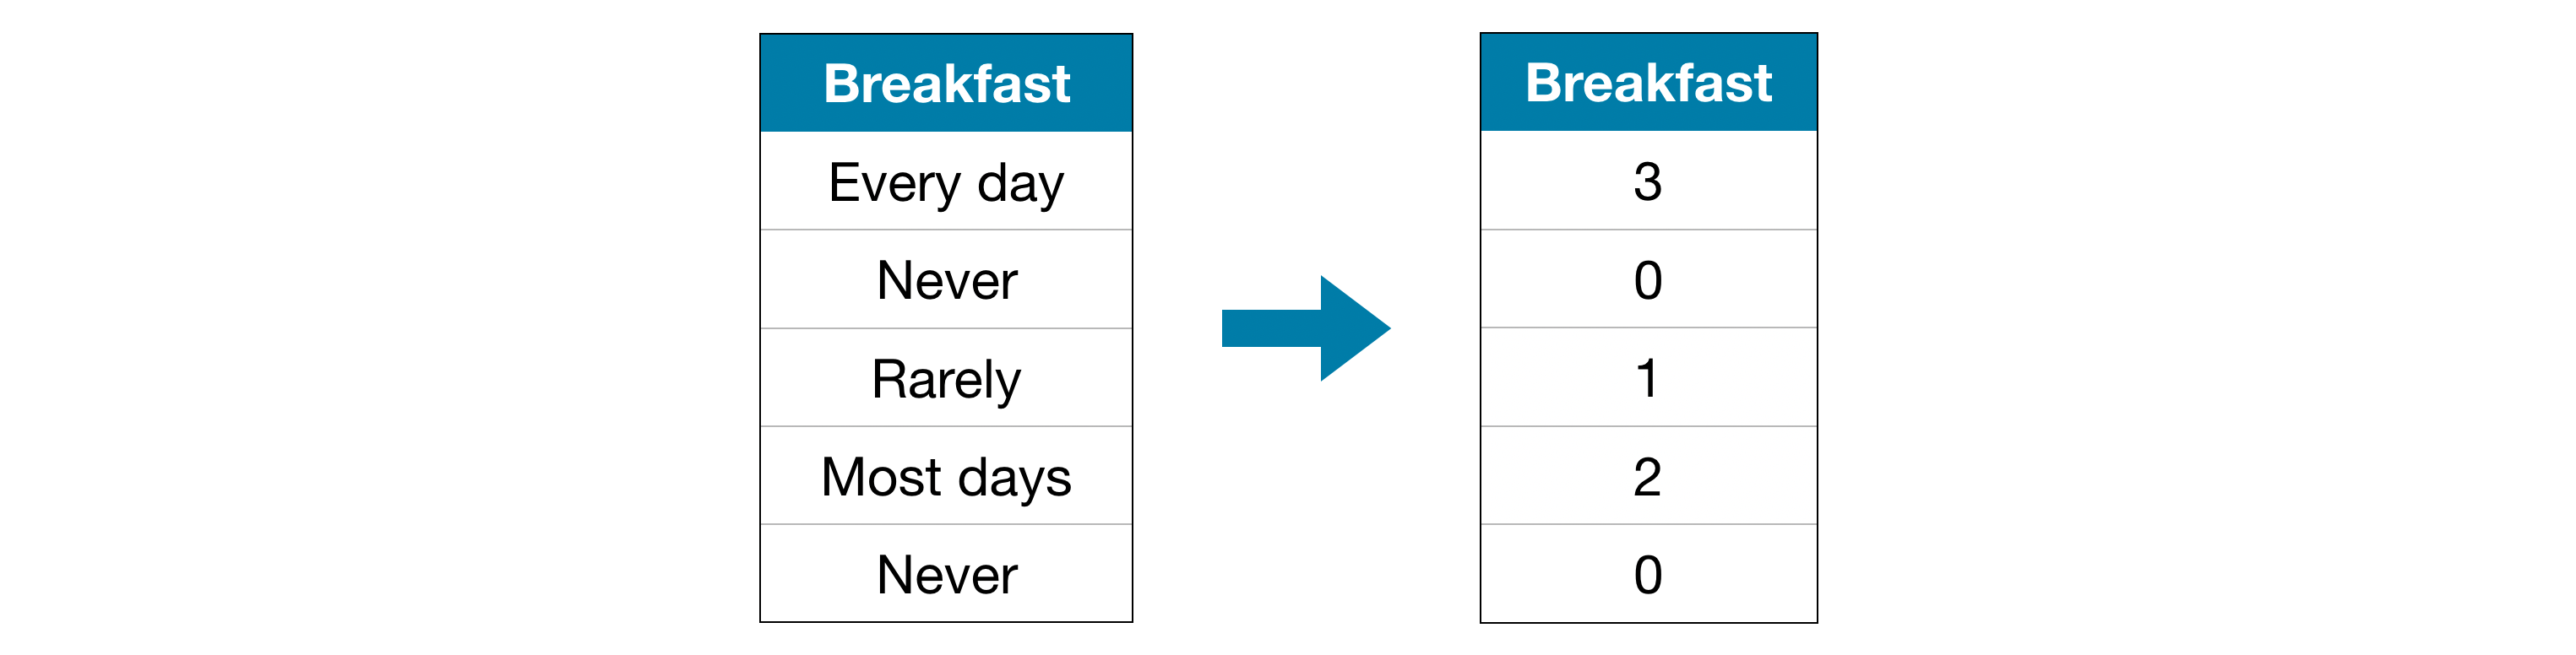

Essa abordagem assume uma ordem das categorias: "Nunca" (0) <"Raramente" (1) <"Na maioria dos dias" (2) <"Todos os dias" (3).

Essa suposição faz sentido neste exemplo, porque há uma classificação indiscutível nas categorias. Nem todas as variáveis categóricas têm uma ordem clara nos valores, mas nos referimos àquelas que funcionam como variáveis ordinais. Para modelos baseados em árvore (como árvores de decisão e florestas aleatórias), você pode esperar que a codificação de rótulo funcione bem com variáveis ordinais.

### 3) Codificação One-Hot
A codificação one-hot cria novas colunas indicando a presença (ou ausência) de cada valor possível nos dados originais. Para entender isso, trabalharemos com um exemplo.

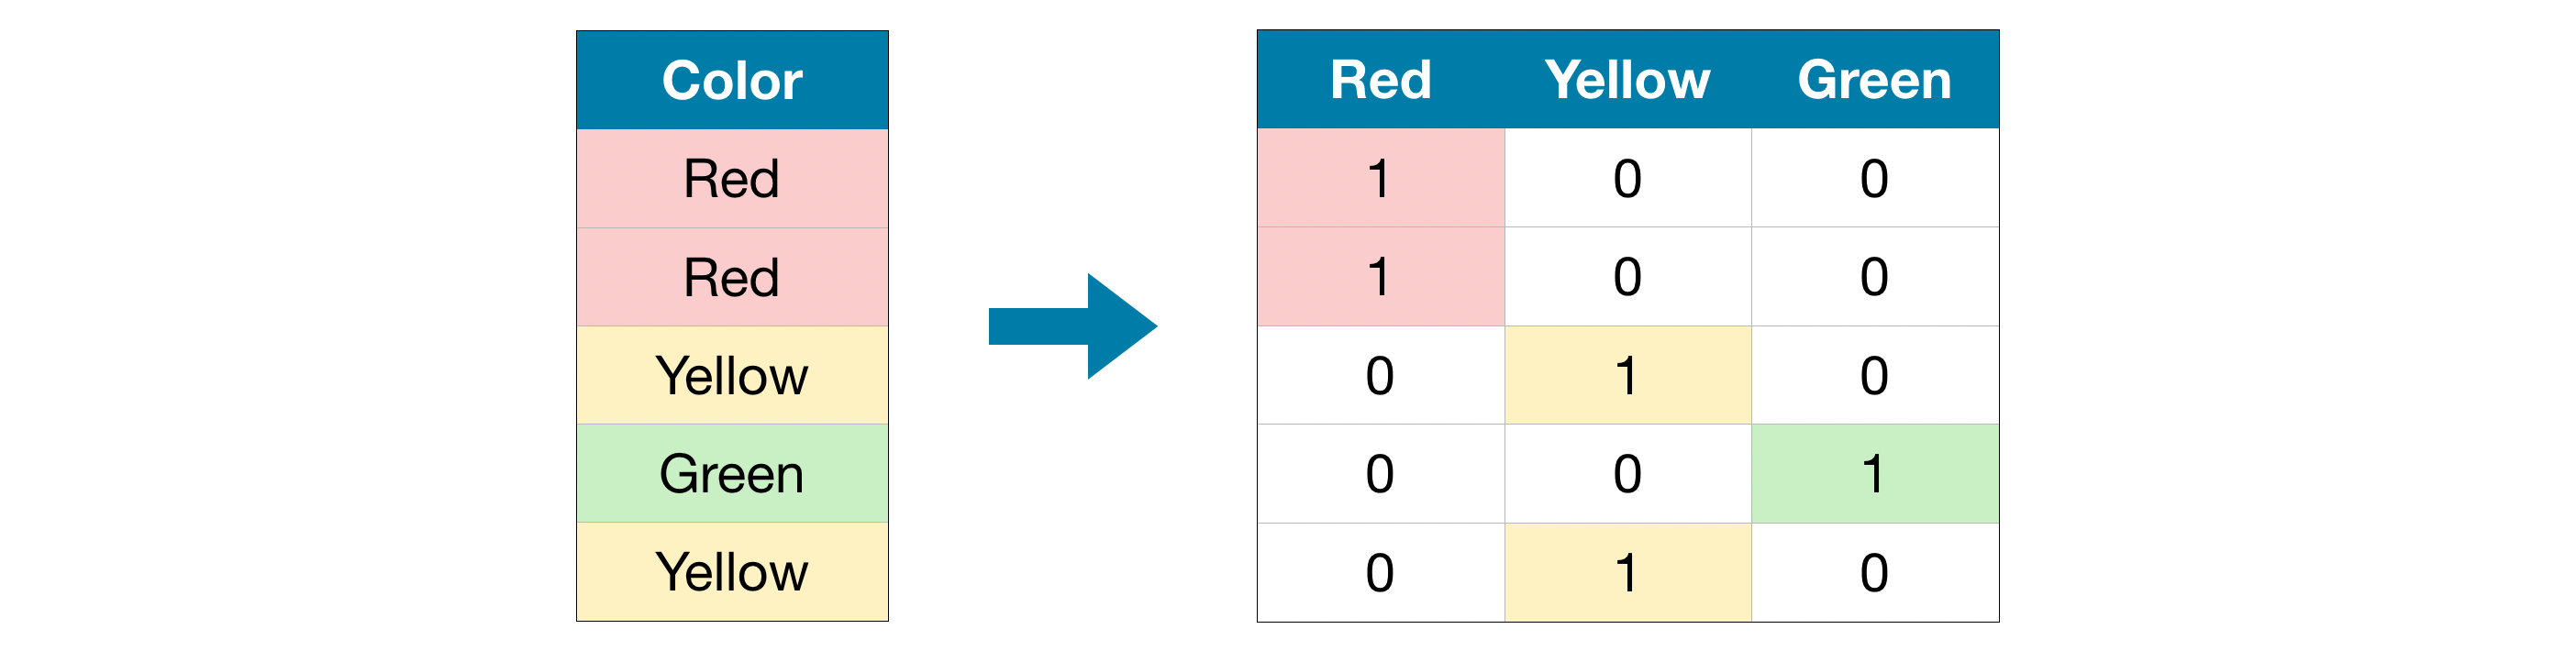

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green". The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset. Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.

In contrast to label encoding, one-hot encoding does not assume an ordering of the categories. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither more nor less than "Yellow"). We refer to categorical variables without an intrinsic ranking as nominal variables.

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than 15 different values).

### Example
As in the previous tutorial, we will work with the __[Melbourne Housing dataset](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot/home)__.

We won't focus on the data loading step. Instead, you can imagine you are at a point where you already have the training and validation data in X_train, X_valid, y_train, and y_valid.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

C:\Users\Carine\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Vamos dar uma olhada nos dados de treinamento com o método *head()* abaixo.

In [2]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


Em seguida, obtemos uma lista de todas as **variáveis categóricas nos dados de treinamento**.

Fazemos isso verificando o **tipo de dados** (ou dtype) de cada coluna. O objeto dtype indica que uma coluna tem texto (há outras coisas que teoricamente poderiam ser, mas isso não é importante para nossos propósitos). Para esse conjunto de dados, as colunas com texto indicam variáveis categóricas.

In [3]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Variáveis Categóricas:")
print(object_cols)

Variáveis Categóricas:
['Type', 'Method', 'Regionname']


### - Definir função para medir a qualidade de cada abordagem
Criaremos uma função *score_dataset()* para comparar as três abordagens diferentes para lidar com variáveis categóricas. Esta função relata **o erro absoluto médio (MAE) de um modelo de floresta aleatório**. Em geral, queremos que o MAE seja o mais baixo possível!

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### 1. Pontuação da abordagem 1 -Descarte de variáveis categóricas-
Soltamos as colunas do objeto com o método *select_dtypes()*.

In [5]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE da Abordagem 1 (Descarte de variáveis categóricas):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE da Abordagem 1 (Descarte de variáveis categóricas):
175703.48185157913


### 2. Pontuação da abordagem 2 -Codificação de etiqueta-
O *Scikit-learn* possui uma classe *LabelEncoder* que pode ser usada para obter codificações de etiquetas. Repetimos as variáveis categóricas e aplicamos o codificador de rótulo separadamente a cada coluna.

In [6]:
from sklearn.preprocessing import LabelEncoder

# Faz uma cópia para evitar mudanças nos dados originais
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Aplica o codificador de rótulos para cada coluna com dados categóricas
label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])

print("MAE da abordagem 2 (Codificação de etiqueta):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE da abordagem 2 (Codificação de etiqueta):
165936.40548390493


Na célula de código acima, para cada coluna, atribuímos aleatoriamente cada valor exclusivo a um número inteiro diferente. Essa é uma abordagem comum que é mais simples do que fornecer rótulos personalizados; no entanto, podemos esperar um aumento adicional no desempenho se fornecermos rótulos mais bem informados para todas as variáveis ordinais.

### 3. Pontuação da abordagem 3 -Codificação One-hot-
Usamos a classe *OneHotEncoder *do *scikit-learn* para obter codificações únicas. Há vários parâmetros que podem ser usados para personalizar seu comportamento:

 - Definimos *handle_unknown = 'ignore'* para evitar erros quando os dados de validação contêm classes que não são representadas nos dados de treinamento;
 - A configuração *sparse = False* garante que as colunas codificadas sejam retornadas como uma matriz numpy (em vez de uma matriz esparsa). <br>
 
Para usar o codificador, fornecemos apenas as colunas categóricas que queremos que sejam codificadas. Por exemplo, para codificar os dados de treinamento, fornecemos *X_train [object_cols]*. (*object_cols* na célula de código abaixo é uma lista dos nomes das colunas com dados categóricos e, portanto, *X_train [object_cols]* contém todos os dados categóricos no conjunto de treinamento.)

In [7]:
from sklearn.preprocessing import OneHotEncoder


# Aplica a codificador one-hot encoder em cada coluna om dados categóricos
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE da abordagem 3 (Codificador One-Hot):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE da abordagem 3 (Codificador One-Hot):
166089.4893009678


### Qual abordagem é a melhor?
Nesse caso, o descarte das colunas categóricas (Abordagem 1) teve pior desempenho, uma vez que teve a maior pontuação no MAE. Quanto às outras duas abordagens, uma vez que as pontuações retornadas do MAE são tão próximas em valor, não parece haver nenhum benefício significativo para uma sobre a outra.

Em geral, a codificação one-hot (Abordagem 3) geralmente apresenta melhor desempenho e a eliminação das colunas categóricas (Abordagem 1) geralmente apresenta pior desempenho, mas varia de acordo com o caso.

### Conclusão
O mundo está cheio de dados categóricos. Você será um cientista de dados muito mais eficaz se souber como usar esse tipo de dados comum!